In [2]:
from spacy.lang.en import English
import spacy
spacy.prefer_gpu()
from collections import Counter
import csv
import config
import tensorflow as tf
import numpy as np
import pandas as pd
import random as rnd
import subprocess
import os
import nltk
from nltk.corpus import stopwords
import re
import string
from collections import OrderedDict, defaultdict
from sklearn.linear_model import LogisticRegression
import fnmatch
#from tensorflow.keras.preprocessing.text import Tokenizer
from src.CustomTokenizer import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import json
from tqdm import tqdm
from data_processing.preprocessing import get_dataset_text, get_word_index_list, write_index_to_file, read_index_as_string

## Load Training set

In [45]:
print("Loading training file from path: ", config.config_io.get('pan_21_processed_train'))
training_data = pd.read_csv(config.config_io.get('pan_21_processed_train'))
training_data.shape

Loading training file from path:  /home/sukanya/PhD/Datasets/PAN SCD/pan21-style-change-detection/processed/train.csv


(66052, 5)

In [46]:
training_data.head()

,problem,author_1,author_2,para1_text,para2_text
0,problem-4845.txt,1,2,I can't see the names (as you've properly reda...,Does it have anything to do that in this parti...
1,problem-4845.txt,2,2,Does it have anything to do that in this parti...,I am having a problem with connectivity in one...
2,problem-4845.txt,2,1,I am having a problem with connectivity in one...,Aliases are a way for the client to be redirec...
3,problem-4845.txt,1,1,Aliases are a way for the client to be redirec...,It doesn't deal with any of that. It specifica...
4,problem-9721.txt,1,2,"There is no non-root command, but a root comma...","For my situation, the use of locking is not su..."


In [47]:
training_data.columns

Index(['problem', 'author_1', 'author_2', 'para1_text', 'para2_text'], dtype='object')

## Load Testing set

In [48]:
print("Loading testing file from path: ", config.config_io.get('pan_21_processed_test'))
testing_data = pd.read_csv(config.config_io.get('pan_21_processed_test'))
testing_data.shape

Loading testing file from path:  /home/sukanya/PhD/Datasets/PAN SCD/pan21-style-change-detection/processed/test.csv


(14095, 5)

In [49]:
testing_data.head()

,problem,author_1,author_2,para1_text,para2_text
0,problem-1543.txt,1,1,"Has anyone done this on Windows 8 or 8.1, usin...",We are trying to set up a web application in a...
1,problem-1543.txt,1,1,We are trying to set up a web application in a...,But this is not sufficient for us. When Chrom...
2,problem-631.txt,1,2,I kust realized that some other PC is also get...,"Because he leased IP address, most likely he j..."
3,problem-631.txt,2,2,"Because he leased IP address, most likely he j...","In general, I advice you against ever transmit..."
4,problem-631.txt,2,1,"In general, I advice you against ever transmit...","My mac is the one that is always on, Both the ..."


## Load the feature set files
We are doing it manually now for greater control. In the future, we must automate to read the files directly form the directory.

In [50]:
def get_feature_set_files(path = '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/'):
    feature_set_files = {}
    sub_folder_list = [name for name in os.listdir(path) if os.path.isdir(path)]
    sub_folder_list.sort()
    for sub_folder in sub_folder_list:
        vocab_files = os.listdir(path+sub_folder+"/")
        vocab_sizes = [int(i.split("w")[0]) for i in vocab_files]
        vocab_files_sorted = [x for _, x in sorted(zip(vocab_sizes, vocab_files))]
        vocab_files_sorted = [path+sub_folder+"/"+file for file in vocab_files_sorted]
        #vocab_files.sort(reverse = True)
        feature_set_files[sub_folder] = vocab_files_sorted
    return feature_set_files

In [51]:
feature_set_files = get_feature_set_files()

In [52]:
feature_set_files

{'opt1': ['/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/50word_list.txt',
  '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/100word_list.txt',
  '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/150word_list.txt',
  '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/200word_list.txt',
  '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/250word_list.txt',
  '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/300word_list.txt',
  '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/350word_list.txt',
  '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/400word_list.txt',
  '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/450word_list.txt',
  '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/500word_list.txt'],
 'opt2': ['/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt2/50word_list.txt',
  '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dat

In [53]:
#nlp = English()
nlp = spacy.load("en_core_web_sm")

In [54]:
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x7f3a407e1820>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f3aeb8a3160>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f3aef122700>)]

In [55]:
# takes micro seconds 90.7 µs ± 962 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each), 100 times faster than below loop
def custom_analyzer(text):
    #doc = nlp(text.lower())
    doc = list(nlp.pipe([text.lower()], disable=["tagger", "parser","ner"]))[0]
    return [t.text for t in doc]

print(custom_analyzer("A very large line this is I don't know how this works yet! God Save me!!"))

['a', 'very', 'large', 'line', 'this', 'is', 'i', 'do', "n't", 'know', 'how', 'this', 'works', 'yet', '!', 'god', 'save', 'me', '!', '!']


In [56]:
metrics = {}
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)#val_loss

for key in list(feature_set_files.keys()):
    print(key)
    temp_metrics_dict={}
    vocab_files = []
    training_acc = []
    training_loss = []
    validation_loss = []
    validation_acc = []
    testing_acc= []
    testing_loss = []
    vocab_size_list = []
    print(key, feature_set_files.get(key))
    for feature_file in feature_set_files.get(key):
        word_tokenizer = Tokenizer(analyzer=custom_analyzer)
        with open(feature_file, "r") as f:
            word_index_str = f.read().replace('\n', '')
        print(word_index_str)
        word_tokenizer.fit_on_texts([word_index_str])
        len_train = len(training_data)
        # define the generators
        from src.DataGenerator import DataGenerator
        training_generator = DataGenerator(training_data.iloc[0:int(0.8*len_train)], tokenizer=word_tokenizer, batch_size=16)
        validation_generator = DataGenerator(training_data.iloc[int(0.8*len_train):], tokenizer=word_tokenizer, batch_size=16)
        testing_generator = DataGenerator(testing_data, tokenizer=word_tokenizer, batch_size=16)

        # this is a hack for "'DataGenerator' object has no attribute 'index'". It turns out that on_epoch_end creates the index that is used
        training_generator.on_epoch_end()
        validation_generator.on_epoch_end()
        testing_generator.on_epoch_end()
        # parameters
        num_classes =2
        num_features = 1

        # define model
        model = Sequential()
        model.add(Dense(50, input_dim=num_features, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(num_classes, activation='softmax'))

        # compile model
        opt = SGD(lr=0.01, momentum=0.9)
        #model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        # fit model
        history = model.fit(training_generator, validation_data=validation_generator, verbose=1, batch_size=16, 
                             epochs=30, steps_per_epoch=100, callbacks=[callback]) #validation_steps=100,

        history_dict = history.history
        vocab_files.append(feature_file.split('/')[-1])
        json.dump(history_dict, open("history_" + key + "_" +feature_file.split('/')[-1], 'w'))
        loss = history_dict['loss'][-1]
        training_loss.append(loss)
        acc = history_dict['accuracy'][-1]
        training_acc.append(acc)
        val_loss = history_dict['val_loss'][-1]
        validation_loss.append(val_loss)
        val_acc = history_dict['val_accuracy'][-1]
        validation_acc.append(val_acc)
        test_loss, test_acc = model.evaluate(testing_generator)
        testing_acc.append(test_acc)
        testing_loss.append(test_loss)
        vocab_size_list.append(feature_file.split('/')[-1])
        print("training acc: ", acc, ", training loss: ", loss, ", val acc: ", val_acc, ", val loss: ", val_loss,", test acc: ", test_acc, ", test loss: ", test_loss)
        print()
    temp_metrics_dict={'vocab_size':vocab_size_list,
        'training_loss' : training_loss,
         'training_acc': training_acc,
         'validation_loss': validation_loss,
         'validation_acc': validation_acc,
         'testing_loss':testing_loss,
         'testing_acc':testing_acc}
    json.dump(temp_metrics_dict, open("total_history_" + key, 'w'))
    metrics[key] = temp_metrics_dict
    

opt1
opt1 ['/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/50word_list.txt', '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/100word_list.txt', '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/150word_list.txt', '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/200word_list.txt', '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/250word_list.txt', '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/300word_list.txt', '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/350word_list.txt', '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/400word_list.txt', '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/450word_list.txt', '/home/sukanya/PhD/Results/011_16_Apr_PAN_21_dataset/vocab/opt1/500word_list.txt']
the to a and you is i of it that in for   on this be if have with your can as not are but or n't 's do will from so an use would / there server one all at my wh

100/100 [==============================] - 10s 102ms/step - loss: 0.6833 - accuracy: 0.5542 - val_loss: 0.6810 - val_accuracy: 0.5664
Epoch 12/30
100/100 [==============================] - 10s 98ms/step - loss: 0.6733 - accuracy: 0.5819 - val_loss: 0.6774 - val_accuracy: 0.5854
Epoch 13/30
100/100 [==============================] - 10s 103ms/step - loss: 0.6800 - accuracy: 0.5856 - val_loss: 0.6768 - val_accuracy: 0.5823
Epoch 14/30
100/100 [==============================] - 10s 102ms/step - loss: 0.6760 - accuracy: 0.5944 - val_loss: 0.6759 - val_accuracy: 0.5812
Epoch 15/30
880/880 [==============================] - 10s 11ms/step - loss: 0.6720 - accuracy: 0.5987
training acc:  0.5806249976158142 , training loss:  0.6751450896263123 , val acc:  0.5826514959335327 , val loss:  0.6755557656288147 , test acc:  0.5986505746841431 , test loss:  0.6719590425491333

the to a and you is i of it that in for   on this be if have with your can as not are but or n't 's do will from so an use wou

100/100 [==============================] - 11s 106ms/step - loss: 0.7042 - accuracy: 0.4649 - val_loss: 0.6904 - val_accuracy: 0.5349
Epoch 2/30
100/100 [==============================] - 10s 105ms/step - loss: 0.6903 - accuracy: 0.5391 - val_loss: 0.6876 - val_accuracy: 0.5781
Epoch 3/30
100/100 [==============================] - 10s 105ms/step - loss: 0.6878 - accuracy: 0.5894 - val_loss: 0.6864 - val_accuracy: 0.5485
Epoch 4/30
100/100 [==============================] - 10s 103ms/step - loss: 0.6879 - accuracy: 0.5447 - val_loss: 0.6844 - val_accuracy: 0.5842
Epoch 5/30
100/100 [==============================] - 10s 103ms/step - loss: 0.6868 - accuracy: 0.5695 - val_loss: 0.6831 - val_accuracy: 0.5852
Epoch 6/30
100/100 [==============================] - 10s 101ms/step - loss: 0.6833 - accuracy: 0.5961 - val_loss: 0.6821 - val_accuracy: 0.5769
Epoch 7/30
100/100 [==============================] - 10s 105ms/step - loss: 0.6826 - accuracy: 0.5807 - val_loss: 0.6806 - val_accuracy: 0.5

Epoch 2/30
100/100 [==============================] - 10s 102ms/step - loss: 0.6903 - accuracy: 0.5620 - val_loss: 0.6882 - val_accuracy: 0.5452
Epoch 3/30
100/100 [==============================] - 10s 103ms/step - loss: 0.6875 - accuracy: 0.5703 - val_loss: 0.6853 - val_accuracy: 0.5644
Epoch 4/30
100/100 [==============================] - 10s 104ms/step - loss: 0.6864 - accuracy: 0.5672 - val_loss: 0.6857 - val_accuracy: 0.5390
Epoch 5/30
100/100 [==============================] - 10s 103ms/step - loss: 0.6819 - accuracy: 0.5572 - val_loss: 0.6806 - val_accuracy: 0.5854
Epoch 6/30
100/100 [==============================] - 10s 104ms/step - loss: 0.6818 - accuracy: 0.5736 - val_loss: 0.6793 - val_accuracy: 0.5833
Epoch 7/30
100/100 [==============================] - 10s 102ms/step - loss: 0.6819 - accuracy: 0.5585 - val_loss: 0.6784 - val_accuracy: 0.5831
Epoch 8/30
100/100 [==============================] - 10s 105ms/step - loss: 0.6801 - accuracy: 0.5791 - val_loss: 0.6764 - val_ac

Epoch 1/30
100/100 [==============================] - 10s 103ms/step - loss: 0.7350 - accuracy: 0.4912 - val_loss: 0.6972 - val_accuracy: 0.4686
Epoch 2/30
100/100 [==============================] - 10s 105ms/step - loss: 0.6939 - accuracy: 0.4962 - val_loss: 0.6900 - val_accuracy: 0.5349
Epoch 3/30
100/100 [==============================] - 10s 102ms/step - loss: 0.6893 - accuracy: 0.5396 - val_loss: 0.6911 - val_accuracy: 0.5349
Epoch 4/30
100/100 [==============================] - 10s 103ms/step - loss: 0.6869 - accuracy: 0.5611 - val_loss: 0.6880 - val_accuracy: 0.5374
Epoch 5/30
100/100 [==============================] - 10s 101ms/step - loss: 0.6887 - accuracy: 0.5378 - val_loss: 0.6870 - val_accuracy: 0.5675
Epoch 6/30
100/100 [==============================] - 10s 103ms/step - loss: 0.6856 - accuracy: 0.5936 - val_loss: 0.6859 - val_accuracy: 0.5389
Epoch 7/30
100/100 [==============================] - 10s 102ms/step - loss: 0.6879 - accuracy: 0.5322 - val_loss: 0.6849 - val_ac

Epoch 1/30
100/100 [==============================] - 11s 107ms/step - loss: 0.7081 - accuracy: 0.4640 - val_loss: 0.6876 - val_accuracy: 0.5404
Epoch 2/30
100/100 [==============================] - 10s 104ms/step - loss: 0.6856 - accuracy: 0.5658 - val_loss: 0.6848 - val_accuracy: 0.5829
Epoch 3/30
100/100 [==============================] - 10s 102ms/step - loss: 0.6877 - accuracy: 0.5591 - val_loss: 0.6836 - val_accuracy: 0.5794
Epoch 4/30
100/100 [==============================] - 10s 104ms/step - loss: 0.6825 - accuracy: 0.5901 - val_loss: 0.6821 - val_accuracy: 0.5704
Epoch 5/30
100/100 [==============================] - 10s 102ms/step - loss: 0.6804 - accuracy: 0.5657 - val_loss: 0.6790 - val_accuracy: 0.5942
Epoch 6/30
100/100 [==============================] - 10s 104ms/step - loss: 0.6758 - accuracy: 0.5984 - val_loss: 0.6771 - val_accuracy: 0.5948
Epoch 7/30
100/100 [==============================] - 10s 104ms/step - loss: 0.6785 - accuracy: 0.5945 - val_loss: 0.6764 - val_ac

Epoch 5/30
100/100 [==============================] - 10s 105ms/step - loss: 0.6813 - accuracy: 0.5766 - val_loss: 0.6813 - val_accuracy: 0.5971
Epoch 6/30
100/100 [==============================] - 10s 104ms/step - loss: 0.6782 - accuracy: 0.6265 - val_loss: 0.6809 - val_accuracy: 0.5745
Epoch 7/30
100/100 [==============================] - 10s 103ms/step - loss: 0.6818 - accuracy: 0.5642 - val_loss: 0.6804 - val_accuracy: 0.5672
Epoch 8/30
880/880 [==============================] - 10s 12ms/step - loss: 0.6783 - accuracy: 0.5612
training acc:  0.5887500047683716 , training loss:  0.6767958998680115 , val acc:  0.5552272796630859 , val loss:  0.6798034310340881 , test acc:  0.5611505508422852 , test loss:  0.6782985925674438

the . , to a and you is i of it that in for   on this be if have with your can as not are but or n't 's do will from so an use would / there server one all at my which then by when what some like using they just need up only more other any also should has was doe

Epoch 1/30
100/100 [==============================] - 10s 103ms/step - loss: 0.7063 - accuracy: 0.5478 - val_loss: 0.6943 - val_accuracy: 0.5391
Epoch 2/30
100/100 [==============================] - 10s 99ms/step - loss: 0.6935 - accuracy: 0.5407 - val_loss: 0.6902 - val_accuracy: 0.5578
Epoch 3/30
100/100 [==============================] - 10s 102ms/step - loss: 0.6899 - accuracy: 0.5525 - val_loss: 0.6887 - val_accuracy: 0.5522
Epoch 4/30
100/100 [==============================] - 10s 101ms/step - loss: 0.6865 - accuracy: 0.5415 - val_loss: 0.6867 - val_accuracy: 0.5600
Epoch 5/30
100/100 [==============================] - 10s 102ms/step - loss: 0.6839 - accuracy: 0.5848 - val_loss: 0.6850 - val_accuracy: 0.5614
Epoch 6/30
100/100 [==============================] - 10s 101ms/step - loss: 0.6877 - accuracy: 0.5472 - val_loss: 0.6858 - val_accuracy: 0.5580
Epoch 7/30
100/100 [==============================] - 10s 100ms/step - loss: 0.6892 - accuracy: 0.5368 - val_loss: 0.6850 - val_acc

Epoch 1/30
100/100 [==============================] - 10s 102ms/step - loss: 0.6906 - accuracy: 0.5438 - val_loss: 0.6839 - val_accuracy: 0.5671
Epoch 2/30
100/100 [==============================] - 10s 101ms/step - loss: 0.6841 - accuracy: 0.5746 - val_loss: 0.6808 - val_accuracy: 0.5761
Epoch 3/30
100/100 [==============================] - 10s 104ms/step - loss: 0.6839 - accuracy: 0.5857 - val_loss: 0.6803 - val_accuracy: 0.5779
Epoch 4/30
100/100 [==============================] - 10s 101ms/step - loss: 0.6870 - accuracy: 0.5504 - val_loss: 0.6790 - val_accuracy: 0.5755
Epoch 5/30
100/100 [==============================] - 10s 101ms/step - loss: 0.6785 - accuracy: 0.5849 - val_loss: 0.6784 - val_accuracy: 0.5774
Epoch 6/30
880/880 [==============================] - 10s 11ms/step - loss: 0.6773 - accuracy: 0.5836
training acc:  0.5475000143051147 , training loss:  0.6849429607391357 , val acc:  0.5778030157089233 , val loss:  0.6782012581825256 , test acc:  0.5835937261581421 , test 

Epoch 1/30
100/100 [==============================] - 10s 103ms/step - loss: 0.6903 - accuracy: 0.5337 - val_loss: 0.6865 - val_accuracy: 0.5576
Epoch 2/30
100/100 [==============================] - 10s 104ms/step - loss: 0.6859 - accuracy: 0.5989 - val_loss: 0.6843 - val_accuracy: 0.5677
Epoch 3/30
100/100 [==============================] - 10s 102ms/step - loss: 0.6813 - accuracy: 0.5865 - val_loss: 0.6846 - val_accuracy: 0.5563
Epoch 4/30
100/100 [==============================] - 10s 101ms/step - loss: 0.6771 - accuracy: 0.5915 - val_loss: 0.6807 - val_accuracy: 0.5741
Epoch 5/30
100/100 [==============================] - 10s 101ms/step - loss: 0.6895 - accuracy: 0.5428 - val_loss: 0.6801 - val_accuracy: 0.5745
Epoch 6/30
100/100 [==============================] - 10s 102ms/step - loss: 0.6776 - accuracy: 0.5681 - val_loss: 0.6796 - val_accuracy: 0.5760
Epoch 7/30
100/100 [==============================] - 10s 99ms/step - loss: 0.6822 - accuracy: 0.5668 - val_loss: 0.6783 - val_acc

Epoch 1/30
100/100 [==============================] - 10s 103ms/step - loss: 0.7079 - accuracy: 0.4811 - val_loss: 0.6885 - val_accuracy: 0.5550
Epoch 2/30
100/100 [==============================] - 10s 102ms/step - loss: 0.6877 - accuracy: 0.5753 - val_loss: 0.6869 - val_accuracy: 0.5855
Epoch 3/30
100/100 [==============================] - 10s 102ms/step - loss: 0.6881 - accuracy: 0.5671 - val_loss: 0.6864 - val_accuracy: 0.5448
Epoch 4/30
100/100 [==============================] - 10s 101ms/step - loss: 0.6881 - accuracy: 0.5289 - val_loss: 0.6867 - val_accuracy: 0.5371
Epoch 5/30
880/880 [==============================] - 10s 11ms/step - loss: 0.6828 - accuracy: 0.5864
training acc:  0.5537499785423279 , training loss:  0.6874681115150452 , val acc:  0.5772727131843567 , val loss:  0.6835704445838928 , test acc:  0.5864346623420715 , test loss:  0.6828195452690125

. ,   n't 's use would / server one like using need also get windows data want could file time way system network make

Epoch 1/30
100/100 [==============================] - 10s 102ms/step - loss: 0.6900 - accuracy: 0.5818 - val_loss: 0.6936 - val_accuracy: 0.5349
Epoch 2/30
100/100 [==============================] - 10s 100ms/step - loss: 0.6897 - accuracy: 0.5643 - val_loss: 0.6901 - val_accuracy: 0.5349
Epoch 3/30
100/100 [==============================] - 10s 100ms/step - loss: 0.6865 - accuracy: 0.5760 - val_loss: 0.6866 - val_accuracy: 0.5923
Epoch 4/30
100/100 [==============================] - 10s 102ms/step - loss: 0.6835 - accuracy: 0.5829 - val_loss: 0.6841 - val_accuracy: 0.5875
Epoch 5/30
100/100 [==============================] - 10s 101ms/step - loss: 0.6847 - accuracy: 0.5729 - val_loss: 0.6824 - val_accuracy: 0.5922
Epoch 6/30
880/880 [==============================] - 10s 11ms/step - loss: 0.6805 - accuracy: 0.5876
training acc:  0.5625 , training loss:  0.6842091083526611 , val acc:  0.5848484635353088 , val loss:  0.6809705495834351 , test acc:  0.5875710248947144 , test loss:  0.680

In [57]:
json.dump(metrics, open("history/total_history_combined", 'w'))

In [58]:
df_opt1 = pd.DataFrame(metrics.get('opt1'))
df_opt2 = pd.DataFrame(metrics.get('opt2'))
df_opt3 = pd.DataFrame(metrics.get('opt3'))
df_opt4 = pd.DataFrame(metrics.get('opt4'))

In [59]:
df_opt1

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
0,50word_list.txt,0.686826,0.553125,0.685477,0.572197,0.684580,0.582884
1,100word_list.txt,0.679861,0.573125,0.679289,0.579015,0.676914,0.594247
2,150word_list.txt,0.686723,0.558125,0.684251,0.578409,0.683203,0.589702
3,200word_list.txt,0.675145,0.580625,0.675556,0.582651,0.671959,0.598651
4,250word_list.txt,0.681178,0.601875,0.682037,0.579470,0.680536,0.593466
5,300word_list.txt,0.679256,0.571875,0.679626,0.581061,0.677249,0.597940
6,350word_list.txt,0.680484,0.586875,0.679262,0.584242,0.677142,0.601491
7,400word_list.txt,0.676427,0.599375,0.679169,0.578561,0.677358,0.584304
8,450word_list.txt,0.678937,0.573125,0.670530,0.587651,0.666508,0.602202
9,500word_list.txt,0.674819,0.594375,0.675964,0.578864,0.673106,0.584588


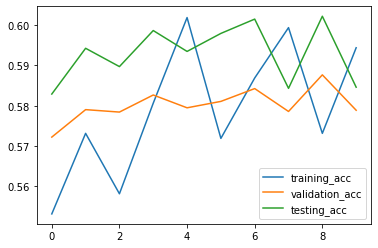

In [66]:
df_opt1[['training_acc','validation_acc', 'testing_acc']].plot()

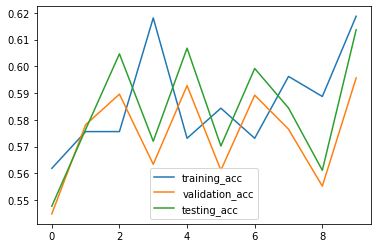

In [67]:
df_opt2[['training_acc','validation_acc', 'testing_acc']].plot()

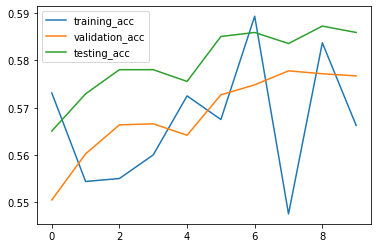

In [68]:
df_opt3[['training_acc','validation_acc', 'testing_acc']].plot()

In [97]:
temp_df_1 = df_opt1.loc[df_opt1['vocab_size'] == '100word_list.txt'].copy()
temp_df_1.index= ["opt1"]
temp_df_1

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
opt1,100word_list.txt,0.656294,0.605,0.658305,0.594183,0.659788,0.585102


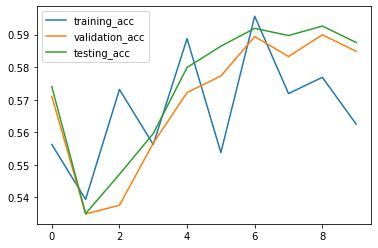

In [69]:
df_opt4[['training_acc','validation_acc', 'testing_acc']].plot()

In [98]:
temp_df_2 = df_opt2.loc[df_opt2['vocab_size'] == '100word_list.txt'].copy()
temp_df_2.index= ["opt2"]
temp_df_2

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
opt2,100word_list.txt,0.630891,0.630625,0.638632,0.614187,0.6476,0.602873


In [99]:
temp_df_3 = df_opt3.loc[df_opt3['vocab_size'] == '100word_list.txt'].copy()
temp_df_3.index= ["opt3"]
temp_df_3

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
opt3,100word_list.txt,0.647728,0.6125,0.650469,0.613862,0.649569,0.611586


In [100]:
temp_df_4 = df_opt4.loc[df_opt4['vocab_size'] == '100word_list.txt'].copy()
temp_df_4.index= ["opt4"]
temp_df_4

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
opt4,100word_list.txt,0.615623,0.636875,0.61408,0.64814,0.616221,0.647084


In [101]:
result = pd.concat([temp_df_1,temp_df_2,temp_df_3, temp_df_4])

In [102]:
result

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
opt1,100word_list.txt,0.656294,0.605000,0.658305,0.594183,0.659788,0.585102
opt2,100word_list.txt,0.630891,0.630625,0.638632,0.614187,0.647600,0.602873
opt3,100word_list.txt,0.647728,0.612500,0.650469,0.613862,0.649569,0.611586
opt4,100word_list.txt,0.615623,0.636875,0.614080,0.648140,0.616221,0.647084


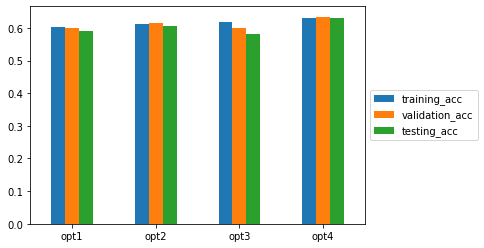

In [96]:
result[['training_acc', 'validation_acc', 'testing_acc']].plot.bar(rot=0).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

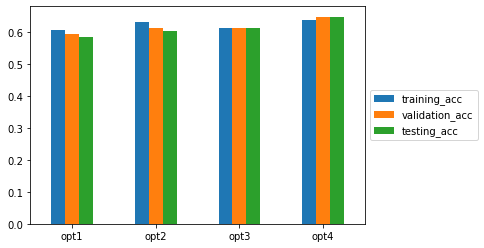

In [103]:
result[['training_acc', 'validation_acc', 'testing_acc']].plot.bar(rot=0).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))